In [10]:
import dask
import dask.dataframe as dd

dask.config.set({"dataframe.convert-string": False})

dataset_path = "./smadex-challenge-predict-the-revenue/train/train"
filters = [("datetime", ">=", "2025-10-01-00-00"), ("datetime", "<", "2025-10-01-12-00")]

ddf = dd.read_parquet(
    dataset_path,
    filters=filters
)

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

target = "iap_revenue_d7"
sample_frac = 1.0  # cambiar a 1.0 para usar todo (puede agotar memoria)

# seleccionar columnas numéricas y eliminar columnas vacías
num_ddf = ddf.select_dtypes(include=["number"])

# eliminar columnas que son todas NaN (dask.DataFrame.dropna no soporta axis)
# usamos el conteo de nulos por columna (se computa)
null_counts = num_ddf.isnull().sum().compute()
# usamos nrows si ya fue calculado; si no, lo computamos aquí
try:
    total_rows = nrows
except NameError:
    total_rows = num_ddf.shape[0].compute()

keep_cols = null_counts[null_counts < total_rows].index.tolist()
num_ddf = num_ddf[keep_cols]

if target not in num_ddf.columns:
    raise KeyError(f"Target {target} not found in numeric columns. Columns sample: {list(num_ddf.columns)[:20]}")

# muestreo para evitar OOM, luego pasar a pandas
sampled = num_ddf.sample(frac=sample_frac, random_state=42).compute()
df = sampled.fillna(0)

X = df.drop(columns=[target])
y = df[target].values

# split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# escalar y entrenar
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [12]:
target = "iap_revenue_d7"
num_ddf = ddf.select_dtypes(include=["number"])

null_counts = num_ddf.isnull().sum().compute()
try:
    total_rows = nrows
except NameError:
    total_rows = num_ddf.shape[0].compute()

keep_cols = null_counts[null_counts < total_rows].index.tolist()
num_ddf = num_ddf[keep_cols]

if target not in num_ddf.columns:
    raise KeyError(f"Target {target} not found")

# CAMBIO: usar data_fraction variable
sampled = num_ddf.sample(frac=1, random_state=42).compute()
df = sampled.fillna(0)

# Preprocesamiento mínimo pero efectivo:
# 1) Remover outliers extremos en target (clip a percentil 99)
q99 = df[target].quantile(0.99)
df[target] = df[target].clip(upper=q99)

# 2) Remover features con varianza casi cero
X = df.drop(columns=[target])
y = df[target].values

# Eliminar columnas con std < 0.01 (prácticamente constantes)
var_threshold = 0.01
high_var_cols = X.columns[X.std() > var_threshold].tolist()
X = X[high_var_cols]

print(f"Datos cargados: {len(X)} muestras, {len(X.columns)} features (data_fraction={1})")
print(f"Target stats: mean={y.mean():.4f}, median={np.median(y):.4f}, std={y.std():.4f}, max={y.max():.4f}")
print(f"Target q99={q99:.4f}")

# split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Datos cargados: 1530501 muestras, 25 features (data_fraction=1)
Target stats: mean=0.2056, median=0.0000, std=1.4498, max=12.5000
Target q99=12.5000


In [14]:
# ===================== PyTorch DNN (classification + regression multitarea) =====================
# Este bloque entrena una red simple que estima P(buyer_d7) y log(iap_revenue_d7) en paralelo.
# La entrada son solo features numéricas; ajusta `torch_sample_frac` si quieres usar más datos.
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score

# ---------- 1) Selección y muestreo de datos numéricos ----------
torch_sample_frac = 1  # sube este valor con más memoria/GPU
target_col = "iap_revenue_d7"
buyer_col = "buyer_d7"
os.makedirs("models", exist_ok=True)

# reutilizamos ddf ya cargado arriba
num_ddf = ddf.select_dtypes(include=["number"])
null_counts = num_ddf.isnull().sum().compute()
total_rows = num_ddf.shape[0].compute()
keep_cols = null_counts[null_counts < total_rows].index.tolist()
required = [target_col, buyer_col]
missing = [col for col in required if col not in keep_cols]
if missing:
    raise ValueError(f"Faltan columnas requeridas en el dataframe numérico: {missing}")
num_ddf = num_ddf[keep_cols]

# muestrear para entrenar rápido
sample_df = num_ddf.sample(frac=torch_sample_frac, random_state=777).compute()
sample_df = sample_df.fillna(0)
feature_cols = [c for c in sample_df.columns if c not in required]
if not feature_cols:
    raise ValueError("No hay columnas de entrada disponibles para el modelo PyTorch.")

X = sample_df[feature_cols].values.astype(np.float32)
y_revenue = sample_df[target_col].values.astype(np.float32)
y_buyer = (sample_df[buyer_col] > 0).astype(np.float32)

# los targets deben tener positivos y negativos para entrenar correctamente
if y_buyer.sum() == 0 or y_buyer.sum() == len(y_buyer):
    raise ValueError("La muestra no contiene ambas clases para buyer_d7; aumenta `torch_sample_frac`.")

# escalado estándar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

stratify_labels = y_buyer if 0 < y_buyer.sum() < len(y_buyer) else None
X_train, X_val, yb_train, yb_val, yr_train, yr_val = train_test_split(
    X_scaled, y_buyer, y_revenue, test_size=0.2, random_state=42, stratify=stratify_labels
)

# ---------- 2) Dataset y DataLoader ----------
class RevenueDataset(Dataset):
    def __init__(self, features, buyer_flag, revenue):
        self.features = torch.from_numpy(features).float()
        # FIX: convertir a numpy si es Series
        buyer_arr = buyer_flag.values if hasattr(buyer_flag, 'values') else buyer_flag
        revenue_arr = revenue.values if hasattr(revenue, 'values') else revenue
        self.buyer = torch.from_numpy(buyer_arr.reshape(-1, 1)).float()
        self.revenue = torch.from_numpy(np.log1p(revenue_arr).reshape(-1, 1)).float()

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        return self.features[idx], self.buyer[idx], self.revenue[idx]

train_ds = RevenueDataset(X_train, yb_train, yr_train)
val_ds = RevenueDataset(X_val, yb_val, yr_val)
batch_size = 2048
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)


# ---------- 3) Definición del modelo multitarea ----------
class RevenueNetDeep(nn.Module):
    def __init__(self, in_features, hidden_sizes=(512, 256, 128, 64, 32), dropout=0.3):
        super().__init__()
        layers = []
        prev = in_features
        for i, h in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.SiLU())
            # Más dropout en capas iniciales
            layers.append(nn.Dropout(dropout if i < 2 else dropout * 0.5))
            prev = h
        self.backbone = nn.Sequential(*layers)
        # Cabezas más complejas (2 capas cada una)
        self.cls_head = nn.Sequential(
            nn.Linear(prev, prev // 2),
            nn.SiLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(prev // 2, 1)
        )
        self.reg_head = nn.Sequential(
            nn.Linear(prev, prev // 2),
            nn.SiLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(prev // 2, 1)
        )

    def forward(self, x):
        shared = self.backbone(x)
        buyer_logit = self.cls_head(shared).squeeze(-1)
        revenue_log = self.reg_head(shared).squeeze(-1)
        return buyer_logit, revenue_log

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RevenueNetDeep(len(feature_cols)).to(device)  # CAMBIO: usar nueva arquitectura
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)  # lr más bajo, weight_decay mayor
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # 50 épocas

pos_weight_value = (len(yb_train) - yb_train.sum()) / (yb_train.sum() + 1e-6)
pos_weight = torch.tensor(pos_weight_value, device=device)
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
mse = nn.MSELoss()
alpha, beta = 0.6, 0.4
epochs = 50  # CAMBIO: más épocas
early_stop_patience = 8

# ---------- 4) Loop de entrenamiento + validación ----------
def evaluate(loader):
    model.eval()
    buyer_probs, buyer_true = [], []
    rev_preds, rev_true = [], []
    with torch.no_grad():
        for xb, yb, yr in loader:
            xb = xb.to(device)
            buyer_logits, revenue_log = model(xb)
            buyer_probs.append(torch.sigmoid(buyer_logits).cpu().numpy())
            buyer_true.append(yb.squeeze(-1).numpy())
            # FIX: usar np.expm1 en vez de torch.expm1 después de .numpy()
            rev_preds.append(np.expm1(revenue_log.cpu().numpy()))
            rev_true.append(np.expm1(yr.squeeze(-1).numpy()))
    buyer_probs = np.concatenate(buyer_probs)
    buyer_true = np.concatenate(buyer_true)
    rev_preds = np.concatenate(rev_preds)
    rev_true = np.concatenate(rev_true)
    expected_rev = np.clip(buyer_probs * rev_preds, 0, None)
    val_rmse = np.sqrt(mean_squared_error(rev_true, expected_rev))
    val_auc = roc_auc_score(buyer_true, buyer_probs) if 0 < buyer_true.sum() < len(buyer_true) else float("nan")
    return val_rmse, val_auc

best_rmse = float("inf")
patience_counter = 0

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0
    for xb, yb, yr in train_loader:
        xb = xb.to(device)
        yb = yb.squeeze(-1).to(device)
        yr = yr.squeeze(-1).to(device)
        optimizer.zero_grad()
        buyer_logits, revenue_log = model(xb)
        buyer_loss = bce(buyer_logits, yb)
        reg_loss = mse(revenue_log, yr)
        loss = alpha * buyer_loss + beta * reg_loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()

    val_rmse, val_auc = evaluate(val_loader)
    print(f"Epoch {epoch}/{epochs} | train_loss={epoch_loss/len(train_loader):.4f} | val_RMSE={val_rmse:.4f} | val_AUC={val_auc:.4f}")
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        patience_counter = 0  # resetear contador
        torch.save({
            "model_state": model.state_dict(),
            "feature_cols": feature_cols,
            "scaler_mean": scaler.mean_,
            "scaler_scale": scaler.scale_,
        }, "models/pytorch_two_head.pt")
        print(f"  ✓ Mejor modelo guardado (RMSE={best_rmse:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stopping en época {epoch} (sin mejora en {early_stop_patience} épocas)")
            break

print(f"Mejor RMSE validación: {best_rmse:.4f}")
val_rmse, val_auc = evaluate(val_loader)
print(f"Resumen final -> RMSE: {val_rmse:.4f}, AUC buyer: {val_auc:.4f}")

Epoch 1/50 | train_loss=0.2444 | val_RMSE=86893.0730 | val_AUC=1.0000
  ✓ Mejor modelo guardado (RMSE=86893.0730)
Epoch 2/50 | train_loss=0.0492 | val_RMSE=2355.5078 | val_AUC=1.0000
  ✓ Mejor modelo guardado (RMSE=2355.5078)
Epoch 3/50 | train_loss=0.0286 | val_RMSE=33575931.1125 | val_AUC=1.0000
Epoch 4/50 | train_loss=0.0234 | val_RMSE=13814667.0718 | val_AUC=1.0000
Epoch 5/50 | train_loss=0.0204 | val_RMSE=77048208.8508 | val_AUC=1.0000
Epoch 6/50 | train_loss=0.0182 | val_RMSE=54672016.0542 | val_AUC=1.0000
Epoch 7/50 | train_loss=0.0162 | val_RMSE=134922692.6234 | val_AUC=1.0000
Epoch 8/50 | train_loss=0.0144 | val_RMSE=33347.0536 | val_AUC=1.0000
Epoch 9/50 | train_loss=0.0127 | val_RMSE=2037669644.4028 | val_AUC=1.0000
Epoch 10/50 | train_loss=0.0115 | val_RMSE=22386313.9385 | val_AUC=1.0000
Early stopping en época 10 (sin mejora en 8 épocas)
Mejor RMSE validación: 2355.5078
Resumen final -> RMSE: 22386313.9385, AUC buyer: 1.0000


=== ESTADÍSTICAS DE PREDICCIÓN ===
Revenue predicho: min=-0.01, max=149.75, mean=0.49
Revenue real:     min=0.00, max=380.00, mean=0.63
Prob buyer:       min=0.0000, max=1.0000, mean=0.0332
Final pred:       min=-0.00, max=149.75, mean=0.50

¿Predicciones explosivas? 0 de 2048 muestras
¿NaNs en predicción? revenue=0, buyer=0


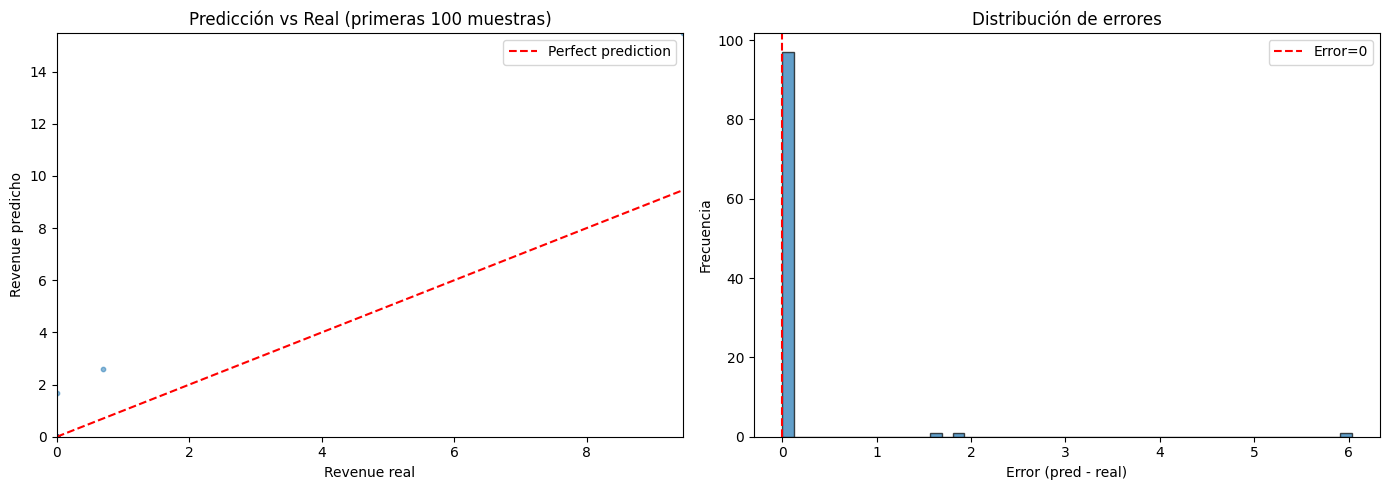


=== COMPARACIÓN CON BASELINE ===
Baseline (predecir media): RMSE = 10.17
Modelo PyTorch:           RMSE = 5.78
Mejora sobre baseline:    43.1%


In [15]:
# Añade esta celda justo después del entrenamiento
# filepath: dnn.ipynb

# ========== DIAGNÓSTICO DEL MODELO ==========
import matplotlib.pyplot as plt

# 1) Comparar predicciones vs ground truth
model.eval()
with torch.no_grad():
    # Tomar un batch de validación
    xb, yb, yr = next(iter(val_loader))
    xb = xb.to(device)
    buyer_logits, revenue_log = model(xb)
    
    buyer_probs = torch.sigmoid(buyer_logits).cpu().numpy()
    revenue_pred = np.expm1(revenue_log.cpu().numpy())
    revenue_true = np.expm1(yr.squeeze(-1).numpy())
    buyer_true = yb.squeeze(-1).numpy()
    
    # Predicción final combinada
    final_pred = buyer_probs * revenue_pred
    
    print("=== ESTADÍSTICAS DE PREDICCIÓN ===")
    print(f"Revenue predicho: min={revenue_pred.min():.2f}, max={revenue_pred.max():.2f}, mean={revenue_pred.mean():.2f}")
    print(f"Revenue real:     min={revenue_true.min():.2f}, max={revenue_true.max():.2f}, mean={revenue_true.mean():.2f}")
    print(f"Prob buyer:       min={buyer_probs.min():.4f}, max={buyer_probs.max():.4f}, mean={buyer_probs.mean():.4f}")
    print(f"Final pred:       min={final_pred.min():.2f}, max={final_pred.max():.2f}, mean={final_pred.mean():.2f}")
    
    # Detectar explosión de gradientes
    print(f"\n¿Predicciones explosivas? {(revenue_pred > 1e6).sum()} de {len(revenue_pred)} muestras")
    print(f"¿NaNs en predicción? revenue={np.isnan(revenue_pred).sum()}, buyer={np.isnan(buyer_probs).sum()}")

# 2) Visualización (solo primeras 100 muestras)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
n_show = min(100, len(revenue_true))

# Scatter real vs predicho
axes[0].scatter(revenue_true[:n_show], final_pred[:n_show], alpha=0.5, s=10)
axes[0].plot([0, revenue_true[:n_show].max()], [0, revenue_true[:n_show].max()], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Revenue real')
axes[0].set_ylabel('Revenue predicho')
axes[0].set_title('Predicción vs Real (primeras 100 muestras)')
axes[0].legend()
axes[0].set_xlim(0, min(revenue_true[:n_show].max(), 1000))  # clip para ver mejor
axes[0].set_ylim(0, min(final_pred[:n_show].max(), 1000))

# Histograma de errores
errors = final_pred[:n_show] - revenue_true[:n_show]
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Error (pred - real)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de errores')
axes[1].axvline(0, color='red', linestyle='--', label='Error=0')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n=== COMPARACIÓN CON BASELINE ===")
# Baseline: siempre predecir la media
baseline_pred = np.full_like(revenue_true, revenue_true.mean())
baseline_rmse = np.sqrt(mean_squared_error(revenue_true, baseline_pred))
model_rmse = np.sqrt(mean_squared_error(revenue_true, final_pred))

print(f"Baseline (predecir media): RMSE = {baseline_rmse:.2f}")
print(f"Modelo PyTorch:           RMSE = {model_rmse:.2f}")
print(f"Mejora sobre baseline:    {((baseline_rmse - model_rmse) / baseline_rmse * 100):.1f}%")

if model_rmse > baseline_rmse * 10:
    print("\n⚠️  MODELO ROTO: RMSE es 10x peor que baseline → overfitting severo")
    print("Causas probables:")
    print("  - Learning rate muy alto → revenue_log explota")
    print("  - Peso de reg_loss (beta) muy bajo → red ignora regresión")
    print("  - Falta de clipping en revenue_log antes de expm1")